In [2]:
import sys
print(sys.path)
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('geolocation.csv','geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rudra@2002',
    database='ecommerce_db',
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Data Analytics/Portfolio'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

['c:\\Python311\\python311.zip', 'c:\\Python311\\DLLs', 'c:\\Python311\\Lib', 'c:\\Python311', '', 'C:\\Users\\RUDRADEB\\AppData\\Roaming\\Python\\Python311\\site-packages', 'c:\\Python311\\Lib\\site-packages', 'c:\\Python311\\Lib\\site-packages\\win32', 'c:\\Python311\\Lib\\site-packages\\win32\\lib', 'c:\\Python311\\Lib\\site-packages\\Pythonwin']
Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
sel

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",user="root",password="Rudra@2002",database="ecommerce_db")

cursor=db.cursor()

#  List all unique cities where customers are located.

In [4]:
query="""select distinct customer_city from customers"""
cursor.execute(query)

data=cursor.fetchall()
df=pd.DataFrame(data,columns=["customer_city"])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [5]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cursor.execute(query)

data=cursor.fetchall()
"Total order placed in 2017 are: ",data[0][0]

('Total order placed in 2017 are: ', 270606)

# Find the total sales per category

In [6]:
query="""select upper(products.product_category) as category,
round(sum(payments.payment_value),2) as sales
from products join order_items 
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""
cursor.execute(query)

data=cursor.fetchall()
df=pd.DataFrame(data, columns=['category','sales'])
df

,category,sales
0,PERFUMERY,1.094556e+08
1,FURNITURE DECORATION,3.089181e+08
2,TELEPHONY,1.051665e+08
3,BED TABLE BATH,3.699116e+08
4,AUTOMOTIVE,1.840956e+08
...,...,...
69,CDS MUSIC DVDS,2.590769e+05
70,LA CUISINE,6.293225e+05
71,FASHION CHILDREN'S CLOTHING,1.697047e+05
72,PC GAMER,4.696769e+05


# Calculate the percentage of orders that were paid in installments

In [7]:
query="""select (sum(case when payment_installments>=1 then 1
else 0 end ))/count(*)*100 from payments"""
cursor.execute(query)

data=cursor.fetchall()
"The percentage of orders that were paid in installments is:", data[0][0]

('The percentage of orders that were paid in installments is:',
 Decimal('99.9981'))

# Count the number of customers from each state.

In [8]:
query="""select customer_state, count(customer_id)
from customers group by customer_state
"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=["State", "Customer_count"])
df=df.sort_values(by="Customer_count", ascending=False)
df.head(10)

,State,Customer_count
0,SP,250476
4,RJ,77112
2,MG,69810
5,RS,32796
3,PR,30270
1,SC,21822
9,BA,20280
13,DF,12840
8,ES,12198
7,GO,12120


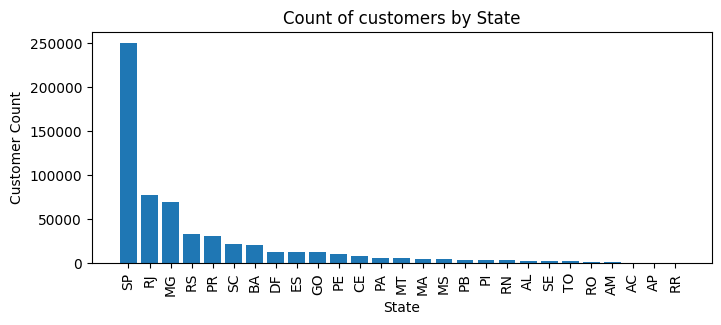

In [9]:
plt.figure(figsize=(8, 3))
plt.bar(df["State"], df["Customer_count"])
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("Count of customers by State")
plt.show()

# Calculate the number of orders per month in 2018

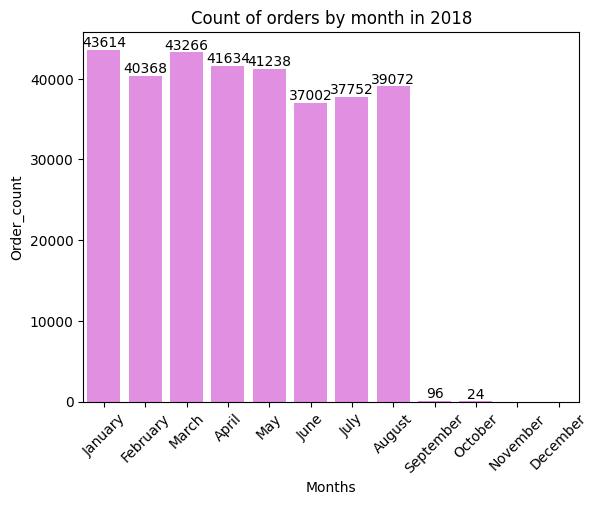

In [10]:
query=""" select monthname(order_purchase_timestamp) as months, count(order_id) as order_count
from orders where year(order_purchase_timestamp)=2018
group by months
"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=["Months", "Order_count"])
o=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
ax=sns.barplot(x=df["Months"],y=df["Order_count"], data=df, order=o, color="violet")
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
ax.bar_label(ax.containers[0])
plt.title("Count of orders by month in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city

In [11]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,252.00
1,celso ramos,234.00
2,datas,216.00
3,candido godoi,216.00
4,matias olimpio,180.00
5,cidelandia,144.00
6,curralinho,144.00
7,picarra,144.00
8,morro de sao paulo,144.00
9,teixeira soares,144.00


# Calculate the percentage of total revenue contributed by each product category

In [12]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,385.11
1,HEALTH BEAUTY,372.70
2,COMPUTER ACCESSORIES,356.50
3,FURNITURE DECORATION,321.61
4,WATCHES PRESENT,321.40


# Identify the correlation between product price and the number of times a product has been purchased.


In [13]:
import numpy as np
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157556


# Calculate the total revenue generated by each seller, and rank them by revenue.

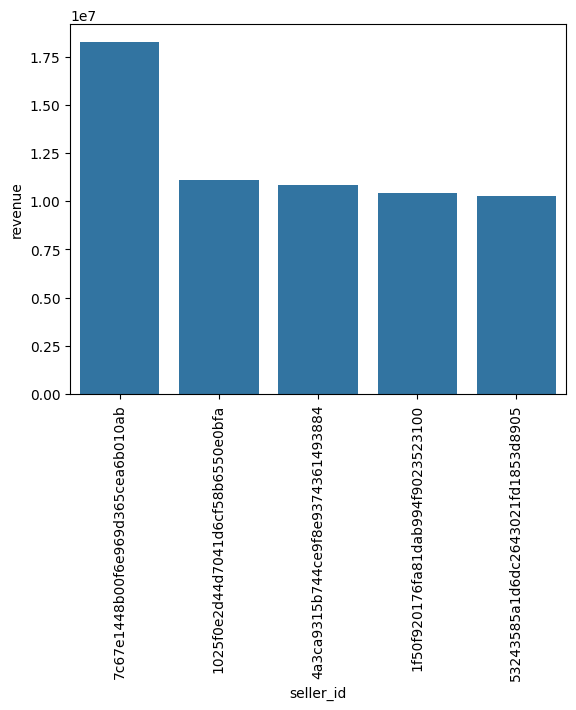

In [14]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [15]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
3739891,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739892,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739893,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739894,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [16]:

query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["years", "months", "payment", "cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,9080.64,9.080640e+03
1,2016,10,2127257.28,2.136338e+06
2,2016,12,706.32,2.137044e+06
3,2017,1,4985569.44,7.122614e+06
4,2017,2,10508688.34,1.763130e+07
5,2017,3,16195089.58,3.382639e+07
6,2017,4,15040369.06,4.886676e+07
7,2017,5,21345077.52,7.021184e+07
8,2017,6,18405949.69,8.861779e+07
9,2017,7,21325785.10,1.099436e+08


# Calculate the year-over-year growth rate of total sales 

In [17]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [18]:

query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cursor.execute(query)
data = cursor.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

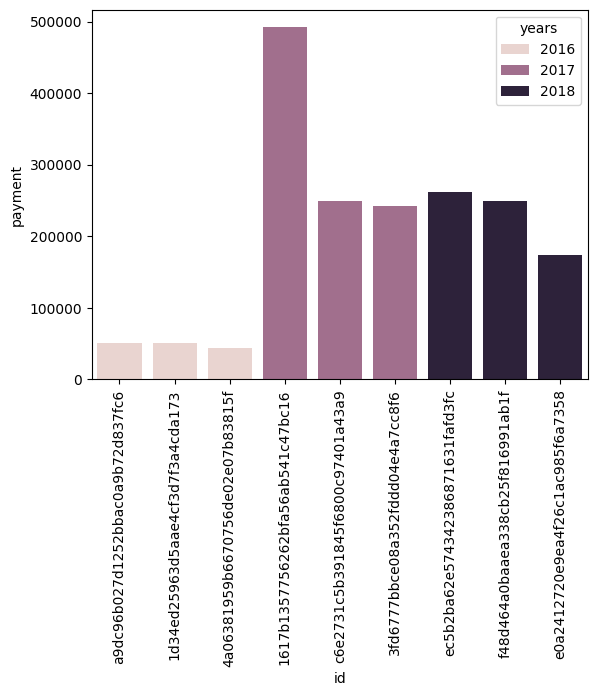

In [20]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()